# Power Plant

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


In [30]:
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext,SparkSession,HiveContext
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [31]:
sc=SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark=SparkSession.builder.getOrCreate()

In [32]:
#raw_data=pd.read_csv("global_power_plant_database.csv")
raw_data=spark.read.csv("global_power_plant_database.csv",inferSchema=True,header=True)

In [33]:
raw_data.show(5)

+-------+------------+--------------------+------------+-----------+--------+---------+------------+-----------+-----------+-----------+------------------+-----+------+--------------------+------------------+-------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------------+
|country|country_long|                name|   gppd_idnr|capacity_mw|latitude|longitude|primary_fuel|other_fuel1|other_fuel2|other_fuel3|commissioning_year|owner|source|                 url|geolocation_source|wepp_id|year_of_capacity_data|generation_gwh_2013|generation_gwh_2014|generation_gwh_2015|generation_gwh_2016|generation_gwh_2017|estimated_generation_gwh|
+-------+------------+--------------------+------------+-----------+--------+---------+------------+-----------+-----------+-----------+------------------+-----+------+--------------------+------------------+-------+---------------------+-------------------+--------------

In [34]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

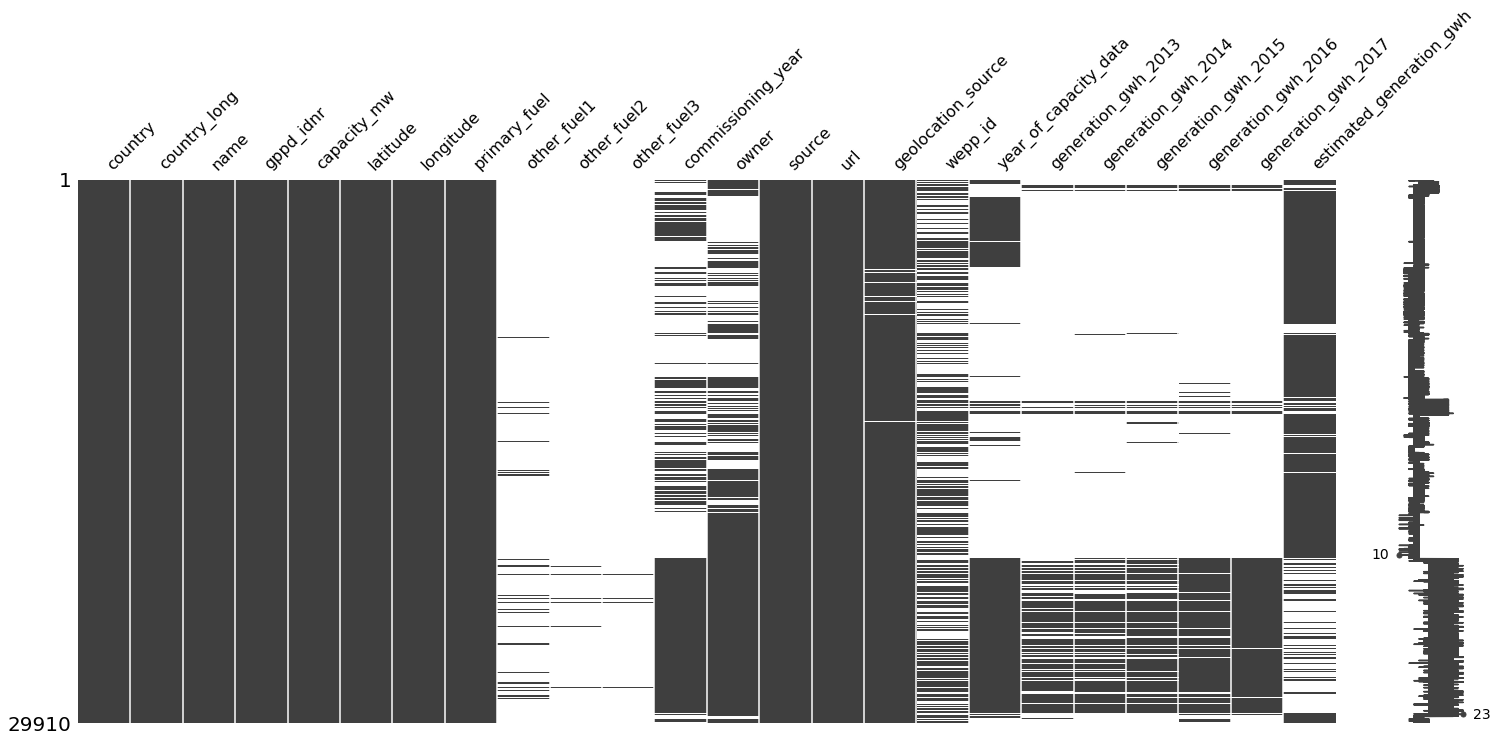

In [35]:
msno.matrix(raw_data.toPandas())

In [36]:
raw_data.printSchema()

root
 |-- country: string (nullable = true)
 |-- country_long: string (nullable = true)
 |-- name: string (nullable = true)
 |-- gppd_idnr: string (nullable = true)
 |-- capacity_mw: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- primary_fuel: string (nullable = true)
 |-- other_fuel1: string (nullable = true)
 |-- other_fuel2: string (nullable = true)
 |-- other_fuel3: string (nullable = true)
 |-- commissioning_year: double (nullable = true)
 |-- owner: string (nullable = true)
 |-- source: string (nullable = true)
 |-- url: string (nullable = true)
 |-- geolocation_source: string (nullable = true)
 |-- wepp_id: string (nullable = true)
 |-- year_of_capacity_data: integer (nullable = true)
 |-- generation_gwh_2013: double (nullable = true)
 |-- generation_gwh_2014: double (nullable = true)
 |-- generation_gwh_2015: double (nullable = true)
 |-- generation_gwh_2016: double (nullable = true)
 |-- generation_gwh_2017: doubl

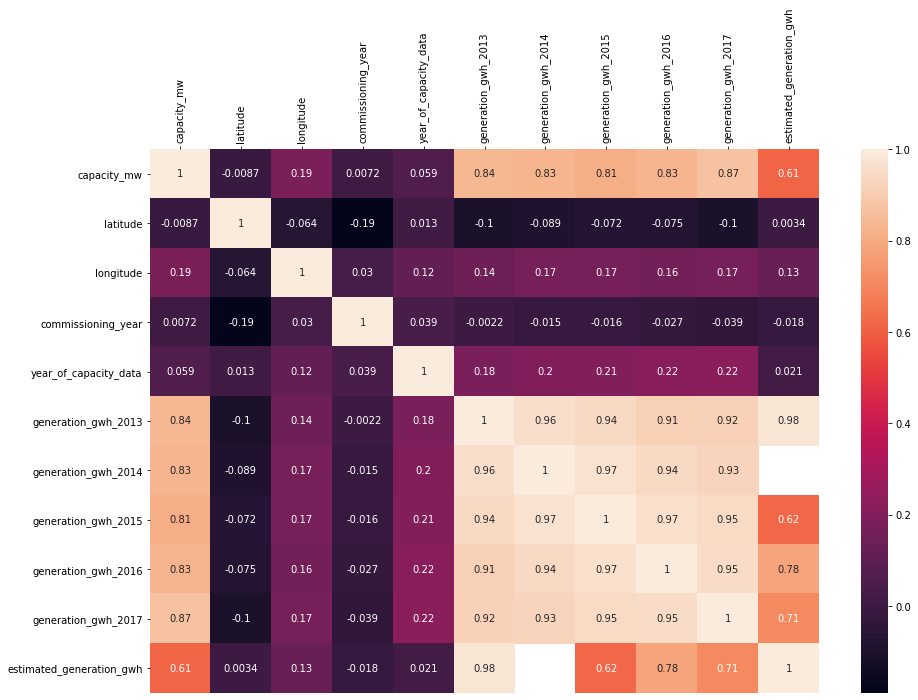

In [37]:
plt.subplots(figsize=(15,10))
hm1=sns.heatmap(raw_data.toPandas().corr(),annot=True)
hm1.set_xticklabels(hm1.get_xticklabels(), rotation=90)
hm1.xaxis.set_ticks_position('top')

In [38]:
#Droping the rows of the row in which we have to predict.
data1=raw_data.na.drop(subset=["estimated_generation_gwh"])

In [39]:
data1.count(),raw_data.count()

(21791, 29910)

In [40]:
missing_val = data1.select([F.count(F.when(F.isnan(i) | \
                                   F.col(i).contains('NA') | \
                                   F.col(i).contains('NULL') | \
                                   F.col(i).isNull(), i)).alias(i) \
                    for i in raw_data.columns])


In [41]:
missing_val.toPandas().transpose()

,0
country,8
country_long,0
name,211
gppd_idnr,0
capacity_mw,0
latitude,0
longitude,0
primary_fuel,0
other_fuel1,21391
other_fuel2,21776


In [ ]:
import pixiedust
display(data1)

country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,commissioning_year,owner,source,url,geolocation_source,wepp_id,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,estimated_generation_gwh
AGO,Angola,Lobito,WRI1023007,20.0,-12.37,13.57,Gas,None,None,None,nan,None,African Development Bank Group,http://powerafrica.opendataforafrica.org,Power Africa,1014566,nan,nan,None,nan,nan,nan,0.0
ARG,Argentina,CENTRAL TERMICA DE CICLO COMBINADO SALTA,ARG0000274,643.0,-24.7456,-65.0513,Gas,Other,None,None,1999.4,AES - TERMOANDES SA,Ministerio de Energía y Minería,http://energia3.mecon.gov.ar/contenidos/archivos/Reorganizacion/informacion_del_mercado/publicaciones/mercado_electrico/estadisticosectorelectrico/2015/A1.POT_GEN_COMB_POR_CENTRAL_2015.xlsx,Ministerio de Energía y Minería,None,2015.0,nan,None,nan,nan,nan,3321.928040828594
ARG,Argentina,CT INDEPENDENCIA,ARG0000336,120.0,-26.8666,-65.2247,Gas,None,None,None,1995.0,GENERACION INDEPENDENCIA SA,Ministerio de Energía y Minería,http://energia3.mecon.gov.ar/contenidos/archivos/Reorganizacion/informacion_del_mercado/publicaciones/mercado_electrico/estadisticosectorelectrico/2015/A1.POT_GEN_COMB_POR_CENTRAL_2015.xlsx,Ministerio de Energía y Minería,1009873,2015.0,nan,None,nan,nan,nan,619.9554664065806
ARG,Argentina,CT REALICO,ARG0000184,24.0,-35.055,-64.2406,Oil,None,None,None,nan,INDUSTRIAS JUAN F. SECCO,Ministerio de Energía y Minería,http://energia3.mecon.gov.ar/contenidos/archivos/Reorganizacion/informacion_del_mercado/publicaciones/mercado_electrico/estadisticosectorelectrico/2015/A1.POT_GEN_COMB_POR_CENTRAL_2015.xlsx,Ministerio de Energía y Minería,None,2015.0,nan,None,nan,nan,nan,391.03168627411753
ARG,Argentina,CT SAENZ PEÑA I,ARG0000062,20.0,-26.8156,-60.4114,Oil,None,None,None,nan,APR ENERGY SRL,Ministerio de Energía y Minería,http://energia3.mecon.gov.ar/contenidos/archivos/Reorganizacion/informacion_del_mercado/publicaciones/mercado_electrico/estadisticosectorelectrico/2015/A1.POT_GEN_COMB_POR_CENTRAL_2015.xlsx,Ministerio de Energía y Minería,None,2015.0,nan,None,nan,nan,nan,325.85973856176463
ARG,Argentina,CT TEREVINTOS,ARG0000057,8.0,-28.4289,-65.7878,Oil,None,None,None,nan,INDUSTRIAS JUAN F. SECCO,Ministerio de Energía y Minería,http://energia3.mecon.gov.ar/contenidos/archivos/Reorganizacion/informacion_del_mercado/publicaciones/mercado_electrico/estadisticosectorelectrico/2015/A1.POT_GEN_COMB_POR_CENTRAL_2015.xlsx,Ministerio de Energía y Minería,None,2015.0,nan,None,nan,nan,nan,130.34389542470583
ARG,Argentina,MAR DE AJO,ARG0000006,34.0,-36.7208,-63.1977,Gas,None,None,None,nan,CENTRALES DE LA COSTA ATLANTICA SA,Ministerio de Energía y Minería,http://energia3.mecon.gov.ar/contenidos/archivos/Reorganizacion/informacion_del_mercado/publicaciones/mercado_electrico/estadisticosectorelectrico/2015/A1.POT_GEN_COMB_POR_CENTRAL_2015.xlsx,Ministerio de Energía y Minería,1011951,2015.0,nan,None,nan,nan,nan,175.65404881519783
ARG,Argentina,SANTA ISABEL,ARG0000181,2.25,-36.2314,-66.9381,Oil,None,None,None,nan,APE,Ministerio de Energía y Minería,http://energia3.mecon.gov.ar/contenidos/archivos/Reorganizacion/informacion_del_mercado/publicaciones/mercado_electrico/estadisticosectorelectrico/2015/A1.POT_GEN_COMB_POR_CENTRAL_2015.xlsx,Ministerio de Energía y Minería,1048709,2015.0,nan,None,nan,nan,nan,36.659220588198515
AUS,Australia,Canning Vale,AUS0000330,4.0,-32.0739,115.8914,Waste,None,None,None,nan,Landfill Gas and Power Pty Ltd,Australian Renewable Energy Mapping Infrastructure,http://services.ga.gov.au/site_3/rest/services/Electricity_Infrastructure/MapServer,Australian Renewable Energy Mapping Infrastructure,1067435,nan,nan,None,nan,nan,nan,0.0
AUS,Australia,Cannington Mine,AUS0000452,40.0,-21.8601,140.9158,Gas,None,None,None,nan,BHP Billiton,Australian Renewable Energy Mapping Infrastructure,http://services.ga.gov.au/site_3/rest/services/Electricity_

In [43]:
#Non Important Cols
cols=["country_long","name","gppd_idnr",""]

In [44]:
data1.toPandas()["latitude"].min(),data1.toPandas()["latitude"].max()

(-53.7862, 71.0109)

In [45]:
data1.toPandas()["longitude"].min(),data1.toPandas()["longitude"].max()

(-179.1338, 177.4995)

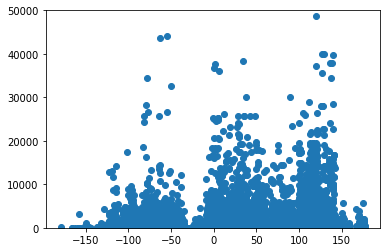

In [46]:
plt.scatter(data1.toPandas()["longitude"],data1.toPandas()["estimated_generation_gwh"])
plt.ylim(ymax = 50000, ymin = 0)
plt.show()

In [47]:
#Grouping the latitude data's
from pyspark.sql.functions import UserDefinedFunction as udf
from pyspark.sql.types import*
def GroupLat(lat):
    if lat>=60:
        return "0"
    elif lat<60 and lat>=40:
        return "1"
    elif lat<40 and lat>=20:
        return "2"
    elif lat<20 and lat>=0:
        return "3"
    elif lat<0 and lat>=-20:
        return "4"
    elif lat<-20 and lat>=-40:
        return "5"
    else:
        return "6"
groupLatUDF=udf(lambda row:GroupLat(row),StringType())
data2=data1.withColumn("latitude",groupLatUDF(data1.latitude))
#Grouping Longitude
def GroupLong(long):
    if long>=150:
        return "0"
    elif long<150 and long>=100:
        return "1"
    elif long<100 and long>=50:
        return "2"
    elif long<50 and long>=0:
        return "3"
    elif long<0 and long>=-50:
        return "4"
    elif long<-50 and long>=-100:
        return "5"
    elif long<-100 and long>=-150:
        return "6"
    else:
        return "7"
    
groupLongUDF=udf(lambda row:GroupLong(row),StringType())
data2=data2.withColumn("longitude",groupLongUDF(data2.longitude))

In [48]:
data2.groupby("latitude").count().show(),data2.groupby("longitude").count().show()

+--------+-----+
|latitude|count|
+--------+-----+
|       3| 1396|
|       0|  642|
|       5| 2061|
|       6|   78|
|       1|10606|
|       4| 1446|
|       2| 5562|
+--------+-----+

+---------+-----+
|longitude|count|
+---------+-----+
|        7|   15|
|        3| 5741|
|        0|  106|
|        5| 4048|
|        6|  963|
|        1| 4196|
|        4| 5320|
|        2| 1402|
+---------+-----+



(None, None)

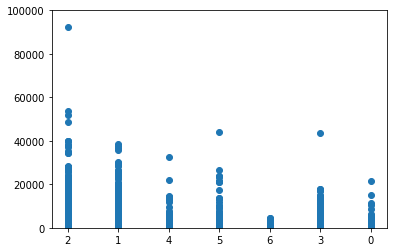

In [49]:
plt.scatter(data2.toPandas()["latitude"],data2.toPandas()["estimated_generation_gwh"])
plt.ylim(ymax = 100000, ymin = 0)
plt.show()

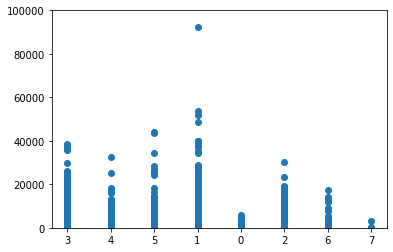

In [50]:
plt.scatter(data2.toPandas()["longitude"],data2.toPandas()["estimated_generation_gwh"])
plt.ylim(ymax = 100000, ymin = 0)
plt.show()

In [51]:
data3=data2.fillna("Not_Any_Fuel",["other_fuel1","other_fuel2","other_fuel3"])
data3=data3.fillna("constants",["owner","source","geolocation_source"])


In [52]:
missing_val = data3.select([F.count(F.when(F.isnan(i) | \
                                   #F.col(i).contains('NA') | \
                                   #F.col(i).contains('NULL') | \
                                   F.col(i).isNull(), i)).alias(i) \
                    for i in data3.columns])
missing_val.toPandas().transpose()

,0
country,0
country_long,0
name,0
gppd_idnr,0
capacity_mw,0
latitude,0
longitude,0
primary_fuel,0
other_fuel1,0
other_fuel2,0


In [53]:
categorical=["country","latitude","longitude","primary_fuel","other_fuel1","other_fuel2","other_fuel3","owner","source","geolocation_source"]
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler,Normalizer
categoricalColumns = categorical
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
#normalizer=Normalizer(inputCol="capacity_mw",outputCol="capacity_mw_normalized",p=1.0)
#stages+=[normalizer]
numericCols = ["capacity_mw"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [54]:
from pyspark.ml import Pipeline
pipeline=Pipeline(stages=stages)
pipelineModel=pipeline.fit(data3)
data4=pipelineModel.transform(data3)
data4.printSchema()

root
 |-- country: string (nullable = true)
 |-- country_long: string (nullable = true)
 |-- name: string (nullable = true)
 |-- gppd_idnr: string (nullable = true)
 |-- capacity_mw: double (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- primary_fuel: string (nullable = true)
 |-- other_fuel1: string (nullable = false)
 |-- other_fuel2: string (nullable = false)
 |-- other_fuel3: string (nullable = false)
 |-- commissioning_year: double (nullable = true)
 |-- owner: string (nullable = false)
 |-- source: string (nullable = false)
 |-- url: string (nullable = true)
 |-- geolocation_source: string (nullable = false)
 |-- wepp_id: string (nullable = true)
 |-- year_of_capacity_data: integer (nullable = true)
 |-- generation_gwh_2013: double (nullable = true)
 |-- generation_gwh_2014: double (nullable = true)
 |-- generation_gwh_2015: double (nullable = true)
 |-- generation_gwh_2016: double (nullable = true)
 |-- generation_gwh_2017:

In [55]:
data4=data4.select(["features","estimated_generation_gwh"])
data4.show()

+--------------------+------------------------+
|            features|estimated_generation_gwh|
+--------------------+------------------------+
|(7044,[107,134,13...|       89.13207547169812|
|(7044,[107,133,13...|      1650.5939902166317|
|(7044,[107,133,13...|       1980.712788259958|
|(7044,[107,133,13...|       16.50593990216632|
|(7044,[107,133,13...|       79.22851153039832|
|(7044,[107,133,13...|       82.52969951083159|
|(7044,[107,133,13...|       825.2969951083159|
|(7044,[107,133,13...|                     0.0|
|(7044,[50,134,139...|       2152.249818828645|
|(7044,[50,134,139...|       293.8648791092957|
|(7044,[50,134,139...|       2317.807497200079|
|(7044,[50,134,139...|       413.8941959285856|
|(7044,[50,134,139...|       1862.523881678635|
|(7044,[50,134,140...|       1862.523881678635|
|(7044,[50,134,139...|        1208.57105211147|
|(7044,[50,134,139...|       4966.730351143026|
|(7044,[50,134,139...|      1730.0777389814875|
|(7044,[50,134,139...|       298.0038210

In [56]:
splits=data4.randomSplit([0.8,0.2])
df_train=splits[0]
df_test=splits[1]

## Defining Model

In [57]:
from pyspark.ml.regression import GBTRegressor
gbt=GBTRegressor(labelCol="estimated_generation_gwh",featuresCol="features",maxIter=10)

In [ ]:
model=gbt.fit(df_train)
train_predictions=model.transform(df_train)
test_predictions=model.transform(df_test)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
binEval=RegressionEvaluator().setPredictionCol("prediction").setLabelCol("estimated_generation_gwh")

In [ ]:
binEval.evaluate()

In [32]:
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [35]:
paramGrid=ParamGridBuilder()\
    .addGrid(gbt.maxBins,[2,4,8,16])\
    .addGrid(gbt.maxDepth,[2,4,8,16])\
    .addGrid(gbt.maxIter,[10,20,50,80,100])\
    .build()

In [41]:
crossVal=CrossValidator(estimator=gbt,estimatorParamMaps=paramGrid,evaluator=binEval,numFolds=4)

In [ ]:
cvModel=crossVal.fit(df_train)